**Overview**

In this example, we are going to use Open CV to detect the Lego piece.  The background of this data set is white, so the best place to test the approach is with a white piece.

**Setup**

We start by importing the libraries we need.  OpenCV imshow doesn't work in this notebook, so we'll need to use matplotlib.

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

#see files in kaggle directory
listfiles=os.listdir("./input")
print(listfiles)

['example_1_Cropped Image.jpg', 'Base Images', 'example_2_Base Image.jpg', 'background_backlit_B.jpg', 'cropped images', 'Cropped Images', 'Image_Count_Summary.jpg', 'base images', 'ImageSetKey.csv', 'background_backlit_A.jpg']


I want to show you what each image looks like after each step, so I am creating a function that will make it easy to preview each image as we go.

OpenCV uses BGR while matplotlib uses RGB, so we need to make sure that put these conversion in so the picture look accurate (you can try previewing without these if you like to test).

In [3]:
# We will be previewing images alongthe way, so lets create a function
def previewImg(text,img_preview,grayscale=False):
    #plt.imshow(img_preview)
    if grayscale==False:
        #convert a color image from BGR to RGB before previewing
        plt.imshow(cv2.cvtColor(img_preview, cv2.COLOR_BGR2RGB))
    else:
        #option for Grayscale images
        plt.imshow(cv2.cvtColor(img_preview, cv2.COLOR_GRAY2RGB))
    plt.title(text)
    plt.show()


Let's load the starting point.  The example image and it's background.

In [4]:
#load the example.  It is a white piece, the most difficult to detect!
img_example=cv2.imread('./input/example_2_Base Image.jpg')

#load a background, so we can extract it and make it easy to detect the object.
img_bg=cv2.imread('./input/background_backlit_A.jpg')

**Staring Point**

Visually this is our starting point (I'm using our defined function above).

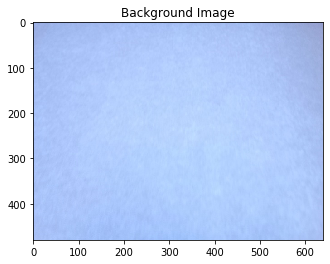

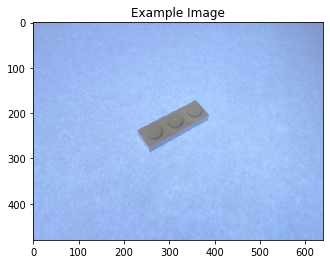

In [5]:
# our starting Point
previewImg('Background Image',img_bg)
previewImg('Example Image',img_example)

**Step 1**

We know proceed to convert these images to Grayscale, and then preview them.

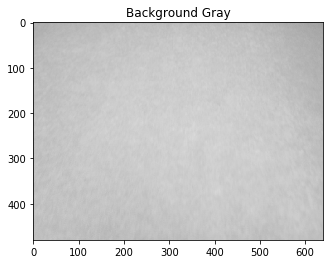

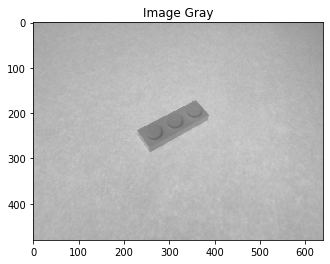

In [6]:
# Background - Gray
img_bg_gray=cv2.cvtColor(img_bg, cv2.COLOR_BGR2GRAY)
previewImg("Background Gray",img_bg_gray,True)
# Image - Gray
img_gray=cv2.cvtColor(img_example, cv2.COLOR_BGR2GRAY)
previewImg("Image Gray",img_gray,True)

**Step 2**

The background is the same in each images, so we will subtract the background from the base image to make sure the object is much more detectable.

The output is the "difference" between both images (you can play around and skipt his step).

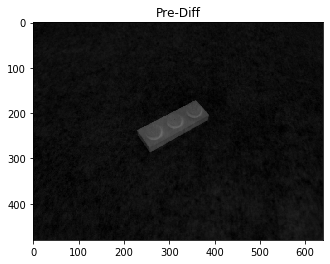

In [7]:
# Calculate Difference
diff_gray=cv2.absdiff(img_bg_gray,img_gray)
previewImg("Pre-Diff",diff_gray,True)

**Step 3**

Apply some Gaussian blur, which makes the image smoother between pixels (and helps us focus the detection on sharper contours).

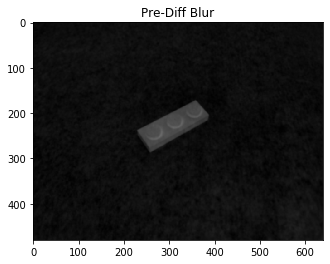

In [8]:
# Diff Blur
diff_gray_blur = cv2.GaussianBlur(diff_gray,(5,5),0)
previewImg("Pre-Diff Blur",diff_gray_blur,True)

**Step 4**

Now we apply Thresholding, which means that the algorithm will decide to placer pixels in either the background or foreground (binary).

We use the Otsu algorithm which iterates across the ideal values for this separation.

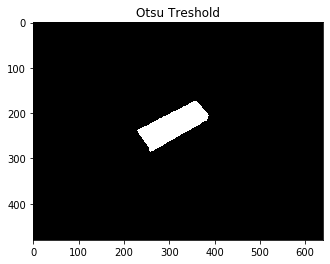

In [9]:
# find otsu's threshold value with OpenCV function
ret, img_tresh = cv2.threshold(diff_gray_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
previewImg("Otsu Treshold",img_tresh,True)

**Step 5**

We use the image from Step 4 to detect the contour using OpenCV findContours function and draw them in green color.

We now have the contours, so we will draw them on top of the Original image.

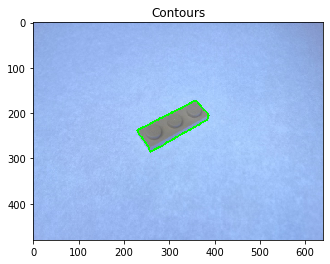

In [15]:
# let's now draw the contour
arr_cnt, hierarchy = cv2.findContours(img_tresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# let's copy the example image, so we don't paint over it
img_with_allcontours=img_example.copy()

cv2.drawContours(img_with_allcontours, arr_cnt, -1, (0,255,0), 3)
previewImg('Contours',img_with_allcontours)

# !!! It may be possible that various contours are showing at this stage, we'll solve that below.

**Optional Step**

It may be possible that we have more than one object/Lego piece in the picture or the algorithm is detecting some noise as contours.

This step here let's us eliminate these "noises".   The data set I'm running this Kernel on is cleaned, this would only apply to real case scenarios.

I run 3 conditions:
* minimum area to consider an object (e.g. anything smaller than a 1x1 brick I will consider noise).
* if the object is sitting in an edge (the brick is clipped)
* if the object has a ratio that exceeds the objects (in this case, the 1x6 plate is the thinnest piece to detect, anything with a longer ratio will be considered noise)

One object detected


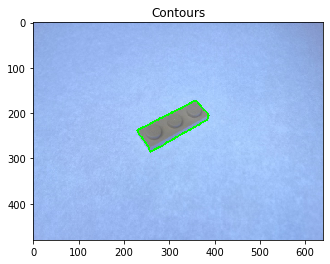

In [16]:
# Just in case, we need to make sure we 'weed out' any contour noise that might generate as images have variations.

# get the dimensions of the image
height, width, channels = img_example.shape

# shorten the variable names
w=width
h=height

validcontours=[]
contour_index=-1

# iterate through each contour found
for i in arr_cnt:

    contour_index=contour_index+1
    ca=cv2.contourArea(i)

    # Calculate W/H Ratio of image
    x,y,w,h = cv2.boundingRect(i)
    aspect_ratio = float(w)/h

    # Flag as edge_noise if the object is at a Corner
    # Contours at the edges of the image are most likely not valid contours
    edge_noise=False
    # if contour starts at x=0 then it's on th edge
    if x==0:
        edge_noise=True
    if y==0:
        edge_noise=True
    # if the contour x value + its contour width exceeds image width, it is on an edge
    if (x+w)==width:
        edge_noise=True
    if (y+h)==height:
        edge_noise=True
            
    # DISCARD noise with measure by area (1x1 round plate dimensions is 1300)
    # if by any chance a contour is drawn on one pixel, this catches it.
    if ca>1300:

        # DISCARD as noise if W/H ratio > 7 to 1 (1x6 plate is 700px to 100px)
        # the conveyor belt has a join line that sometimes is detected as a contour, this ignores it based on w/h ratio
        if aspect_ratio<=6:
            
            # DISCARD if at the Edge
            if edge_noise==False:
                validcontours.append(contour_index)

# copy the original picture
img_withcontours=img_example.copy()
                
# call out if more than 1 valid contour is found
if len(validcontours)>1:
    print("There is more than 1 object in the picture")
else:
    if len(validcontours)==1:
        print("One object detected")
    else:
        print("No objects detected")
        # FYI: code below will most likely error out as it tries to iterate on an array
    
# it might be possible we have more than 1 validcontour, iterating through them here
# if there is zero contours, this most likely will error out
for i in validcontours:                           
    cv2.drawContours(img_withcontours, arr_cnt,validcontours[i], (0,255,0), 3)
    previewImg('Contours',img_withcontours)



**Optional Step**

If you need to crop the image, it will be useful to be able to identify a rectangle.

To achieve this, use OpenCV bounding rectangle function.

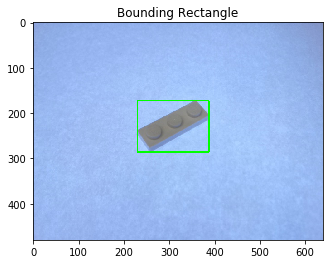

In [17]:
# Display a Bounding Rectangle
img_withrectangle=img_example.copy()
for i in validcontours:
    x,y,w,h = cv2.boundingRect(arr_cnt[i])
    cv2.rectangle(img_withrectangle,(x,y),(x+w,y+h),(0,255,0),2)
    previewImg('Bounding Rectangle',img_withrectangle)